In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from yf_utils import _2_split_train_val_test, _3_random_slices, _4_lookback_slices
from yf_utils import _5_perf_ranks, _6_grp_tuples_sort_sum
from myUtils import pickle_load, pickle_dump

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 14)
pd.set_option('display.max_colwidth', 16)
pd.set_option('display.width', 800)

# verbose = False  # True prints more output
verbose = True  # True prints more output

path_dir = "C:/Users/ping/MyDrive/stocks/yfinance/"
path_data_dump = path_dir + "VSCode_dump/"
fp_df_close_clean = 'df_close_clean'
fp_df_eval_results = 'df_eval_results'

df_close_clean = pickle_load(path_data_dump, fp_df_close_clean)

In [2]:
# Split df_close_clean into training (df_train), validation (df_val) and test (df_test) set.
# The default split is 0.7, 0.2, 0.1 respectively.

###################################
# df_train, df_val, df_test = _2_split_train_val_test(df_close_clean, s_train=1, s_val=0, s_test=0)
df_train, df_val, df_test = _2_split_train_val_test(df_close_clean)
###################################

len_df_train = len(df_train)
len_df_val = len(df_val)
len_df_test = len(df_test)
print(f'len_df_train: {len_df_train}, len_df_val: {len_df_val}, len_df_test: {len_df_test} ')

len_df_train: 1050, len_df_val: 300, len_df_test: 150 


In [3]:
# if store_results:  # record results to df
# my_cols = ['n_samples', 'days_lookbacks', 'days_eval', 'n_top_syms', 'syms_start', 'syms_end', 'grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std', 'grp(CAGR/UI)_mean/std', 'SPY_CAGR/UI']
df_eval_results = pickle_load(path_data_dump, fp_df_eval_results)

In [4]:
# write run results to df_eval_results
store_results = False
# store_results = True

# number of max lookback tuples to create for iloc start_train:end_train:end_eval
# i.e. number of grp_top_set_syms_n_freq and grp_top_set_syms 
# n_samples = 400  
n_samples = 2

# for training, the number of days to lookback from iloc max-lookback end_train
# days_lookbacks = [15, 30, 60, 120]
# days_lookbacks = [30, 60, 120]
days_lookbacks = [60, 120]
# days_lookbacks = [120]
days_lookbacks.sort()

# number of days from end_train are used to evaluate effectiveness of the training
days_eval = 10  

# number of the most-common symbols from days_lookbacks' performance rankings to keep
# n_top_syms = 5
n_top_syms = 10  

syms_start = 0  #  start index of n_top_syms for evaluation
syms_end = 2  #  end index of n_top_syms for evaluation

create a sets of iloc lookback slices (start_train:end_train:end_eval), where  
end_train - start_train = days_lookback  
end_eval - end_train = days_eval  
for example,  
if given:  
 n_samples = 2  
 days_lookbacks = [30, 60, 120]  
 days_eval = 10  
a possible result is:  
 max_lookback_slices:  
 [(150, 270, 280), (5, 125, 135)]  
 where 270-150=125-5=max(days_lookbacks), 280-270=135-125=days_eval  
 sets_lookback_slices:  
 [[(240, 270, 280), (210, 270, 280), (150, 270, 280)], [(95, 125, 135), (65, 125, 135), (5, 125, 135)]]  
  where in a set, 270-240=days_lookbacks[0], 270-210=days_lookbacks[1], 270-150=days_lookbacks[2]  
  and 270, i.e. end_train, is constant for the set  

In [5]:
# return n_samples slices
max_lookback_slices = _3_random_slices(len_df_train, n_samples=n_samples, days_lookback=max(days_lookbacks), days_eval=days_eval)
# return n_samples * len(days_lookbacks) slices
sets_lookback_slices = _4_lookback_slices(max_slices=max_lookback_slices, days_lookbacks=days_lookbacks, verbose=False)

if verbose:
  print(f'max_lookback_slices:\n{max_lookback_slices}')
  print(f'sets_lookback_slices:\n{sets_lookback_slices}')

max_lookback_slices:
[(816, 936, 946), (534, 654, 664)]
sets_lookback_slices:
[[(876, 936, 946), (816, 936, 946)], [(594, 654, 664), (534, 654, 664)]]


Generate lists, n_samples long, of the highest performance ranked symbols. The performance metrics are: CAGR/UI, CAGR/retnStd, retnStd/UI. n_top_syms of the best performing symbols from each metric are combined. The symbols are sorted by their number of appearances in the combined pool, and are placed in a list. A slice of the best performing symbols is selected by syms_start:syms_end, i.e. top_set_syms_n_freq[syms_start:syms_end].     

The performance metrics are calculated based on slices in sets_lookback_slices.  The first two numbers are ilocs for training. The last two numbers are ilocs for evaluation.

In [6]:
grp_top_set_syms_n_freq = []  # list of lists of top_set_symbols_n_freq, there are n_samples lists in list
grp_top_set_syms = []  # list of lists of top_set_symbols, there are n_samples lists in list
# loop thru lists of tuples of start_train:end_train:end_eval, i.e.
#  [[(887, 917, 927), (857, 917, 927), (797, 917, 927)],
#  [(483, 513, 523), (453, 513, 523), (393, 513, 523)]]
for lb_slices in sets_lookback_slices:
  grp_most_common_syms = []  
  for lb_slice in lb_slices:  # lb_slice, e.g. (246, 276, 286)
    start_train = lb_slice[0]
    end_train = lb_slice[1]
    start_eval = end_train
    end_eval = lb_slice[2]
    lookback = end_train - start_train
    d_eval = end_eval - start_eval

    if verbose:
      print(f'days lookback: {lookback}')
      print(f'lb_slices:     {lb_slices}')
      print(f'lb_slice:      {lb_slice}')
      print(f'days eval:     {d_eval}')    
      print(f'start_train:   {start_train}')
      print(f'end_train:     {end_train}')
      # print(f'start_eval:    {start_eval}')
      # print(f'end_eval:      {end_eval}')`

    _df = df_train.iloc[start_train:end_train]
    perf_ranks, most_common_syms = _5_perf_ranks(_df, n_top_syms=n_top_syms)
    grp_most_common_syms.append(most_common_syms)
    
    if verbose:    
      # 1 lookback of r_CAGR/UI, r_CAGR/retnStd, r_retnStd/UI
      print(f'perf_ranks: {perf_ranks}')  
      # most common symbols of perf_ranks 
      print(f'most_common_syms: {most_common_syms}')     
      # grp_perf_ranks[lookback] = perf_ranks
      print(f'+++ finish lookback slice {lookback} +++\n')

  if verbose:
    print(f'grp_most_common_syms: {grp_most_common_syms}')
    # grp_most_common_syms a is list of lists of tuples of 
    #  the most-common-symbols symbol:frequency cumulated from
    #  each days_lookback  
    print(f'**** finish lookback slices {lb_slices} ****\n')

  # flatten list of lists of (symbol:frequency)
  flat_grp_most_common_syms = [val for sublist in grp_most_common_syms for val in sublist]
  # group symbols from set of days_lookbacks (i.e. lb_slices) and sum frequency of the symbols
  set_most_common_syms = _6_grp_tuples_sort_sum(flat_grp_most_common_syms, reverse=True)
  # get the top few most-frequent symbol:frequency pairs
  top_set_syms_n_freq = set_most_common_syms[0:n_top_syms]
  # get symbols from top_set_syms_n_freq

###################################  
  # top_set_syms = [i[0] for i in top_set_syms_n_freq]
  top_set_syms = [i[0] for i in top_set_syms_n_freq[syms_start:syms_end]]  
###################################  
  
  grp_top_set_syms_n_freq.append(top_set_syms_n_freq)
  grp_top_set_syms.append(top_set_syms)

  if verbose:  
    print(f'top {n_top_syms} ranked symbols and frequency from set {lb_slices}:\n{top_set_syms_n_freq}')
    print(f'top {n_top_syms} ranked symbols from set {lb_slices}:\n{top_set_syms}')  
    print(f'===== finish top {n_top_syms} ranked symbols from days_lookback set {lb_slices} =====\n\n')

days lookback: 60
lb_slices:     [(876, 936, 946), (816, 936, 946)]
lb_slice:      (876, 936, 946)
days eval:     10
start_train:   876
end_train:     936
perf_ranks: {'period-60': {'r_CAGR/UI': array(['LOB', 'SPWR', 'GME', 'OLN', 'GOGO', 'STAA', 'BLFS', 'MEOH', 'BKE',
       'SLM'], dtype=object), 'r_CAGR/retnStd': array(['SPWR', 'LOB', 'GME', 'GOGO', 'OLN', 'DDS', 'STAA', 'NVCR', 'HDB',
       'BLFS'], dtype=object), 'r_retnStd/UI': array(['ALGN', 'STAA', 'LOB', 'BKE', 'BLFS', 'BFAM', 'MEOH', 'SCHW',
       'OLN', 'GKOS'], dtype=object)}}
most_common_syms: [('LOB', 3), ('OLN', 3), ('STAA', 3), ('BLFS', 3), ('SPWR', 2), ('GME', 2), ('GOGO', 2), ('MEOH', 2), ('BKE', 2), ('SLM', 1), ('DDS', 1), ('NVCR', 1), ('HDB', 1), ('ALGN', 1), ('BFAM', 1), ('SCHW', 1), ('GKOS', 1)]
+++ finish lookback slice 60 +++

days lookback: 120
lb_slices:     [(876, 936, 946), (816, 936, 946)]
lb_slice:      (816, 936, 946)
days eval:     10
start_train:   816
end_train:     936
perf_ranks: {'period-120': {'r

In [7]:
print('z_grp_top_set_syms:')
z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms)
for item in z_grp_top_set_syms:
  print(item)

z_grp_top_set_syms:
((816, 936, 946), ['LOB', 'SPWR'])
((534, 654, 664), ['FTSM', 'IRT'])


In [8]:
from yf_utils import _7_perf_eval

print('z_grp_top_set_syms:')
z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms)
# z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms[26:29])

for i, (_lookback_slice, _top_set_syms) in enumerate(z_grp_top_set_syms):
# for i, (_lookback_slice, _top_set_syms) in enumerate(z_grp_top_set_syms[26:29]):

  start_train = _lookback_slice[0]
  end_train = _lookback_slice[1]
  start_eval = end_train
  end_eval = _lookback_slice[2]

  print(f'{i + 1 } of {n_samples} max_lookback_slice')
  print(f'max_lookback_slice: {_lookback_slice}')
  # dates correspond to max_lookback_slice
  d_start_train = df_train.index[start_train].strftime('%Y-%m-%d')
  d_end_train = df_train.index[end_train].strftime('%Y-%m-%d')
  d_start_eval = d_end_train
  d_end_eval = df_train.index[end_eval].strftime('%Y-%m-%d')
  d_df_eval_start = d_end_train
  d_df_eval_end = df_train.index[end_eval - 1].strftime('%Y-%m-%d')  
  print(f'max lookback dates: {d_start_train}, {d_end_train}, {d_end_eval}')
  print(f'df_eval dates (inclusive): {d_df_eval_start} - {d_df_eval_end}')    
  print(f'top_set_syms: {_top_set_syms}\n')

  # df_eval to show _top_set_syms along with SPY 
  symbols_eval = _top_set_syms.copy()
  symbols_eval.append('SPY')
  print(f'symbols_eval: {symbols_eval}, _top_set_syms: {_top_set_syms}')
  df_eval = df_train[start_eval:end_eval][symbols_eval]

  if verbose:
    # print(f'start_eval: {start_eval}')
    # print(f'end_eval:   {end_eval}')  
    print(f'start_eval: {start_eval},  date: {d_end_train}')
    print(f'end_eval:   {end_eval},  date: {d_end_eval},  df_eval last date: {d_df_eval_end}')      
    print(f'\ndf_eval:\n{df_eval}\n')


  _, grp_retnStd_d_UI, grp_CAGR_d_retnStd, grp_CAGR_d_UI = _7_perf_eval(df_eval)
  print(f'grp(retnStd/UI):   mean, std, mean/std: {grp_retnStd_d_UI[0]:>13,.3f}, {grp_retnStd_d_UI[1]:>13,.3f}, {grp_retnStd_d_UI[2]:>13,.3f}')
  print(f'grp(CAGR/retnStd): mean, std, mean/std: {grp_CAGR_d_retnStd[0]:>13,.3f}, {grp_CAGR_d_retnStd[1]:>13,.3f}, {grp_CAGR_d_retnStd[2]:>13,.3f}')
  print(f'grp(CAGR/UI):      mean, std, mean/std: {grp_CAGR_d_UI[0]:>13,.3f}, {grp_CAGR_d_UI[1]:>13,.3f}, {grp_CAGR_d_UI[2]:>13,.3f}')

  _sym_idx = ['SPY']
  df_SPY = df_train[start_eval:end_eval][_sym_idx]
  _, SPY_retnStd_d_UI, SPY_CAGR_d_retnStd, SPY_CAGR_d_UI = _7_perf_eval(df_SPY)
  print(f'\nSPY: retnStd/UI, CAGR/retnStd, CAGR/UI: {SPY_retnStd_d_UI[0]:>13,.3f}, {SPY_CAGR_d_retnStd[0]:>13,.3f}, {SPY_CAGR_d_UI[0]:>13,.3f}')

  if store_results:  # record results to df
    row_add = [n_samples, str(days_lookbacks), days_eval, n_top_syms, syms_start, syms_end, grp_CAGR_d_UI[0], grp_CAGR_d_UI[1], grp_CAGR_d_UI[2], SPY_CAGR_d_UI[0]]
    df_eval_results.loc[len(df_eval_results)] = row_add
    print(f'appended row_add to df_eval_results:\n{row_add}\n')
  print('='*50, '\n')  

z_grp_top_set_syms:
1 of 2 max_lookback_slice
max_lookback_slice: (816, 936, 946)
max lookback dates: 2020-05-21, 2020-11-10, 2020-11-24
df_eval dates (inclusive): 2020-11-10 - 2020-11-23
top_set_syms: ['LOB', 'SPWR']

symbols_eval: ['LOB', 'SPWR', 'SPY'], _top_set_syms: ['LOB', 'SPWR']
start_eval: 936,  date: 2020-11-10
end_eval:   946,  date: 2020-11-24,  df_eval last date: 2020-11-23

df_eval:
                  LOB       SPWR         SPY
Date                                        
2020-11-10  43.114334  18.570000  350.240570
2020-11-11  42.655144  19.510000  352.842346
2020-11-12  42.036228  18.730000  349.419434
2020-11-13  43.304005  18.990000  354.256989
2020-11-16  45.220638  19.730000  358.678986
2020-11-17  45.570026  20.440001  356.749908
2020-11-18  44.551815  19.850000  352.456482
2020-11-19  44.022739  21.030001  353.940399
2020-11-20  43.653385  21.700001  351.516693
2020-11-23  44.811356  21.930000  353.623810

grp(retnStd/UI):   mean, std, mean/std:         1.315,     

In [9]:
# https://towardsdatascience.com/pandas-groupby-a-simple-but-detailed-tutorial-314b8f37005d
# https://towardsdatascience.com/accessing-data-in-a-multiindex-dataframe-in-pandas-569e8767201d
# https://towardsdatascience.com/summarizing-data-with-pandas-crosstab-efc8b9abecf
# https://towardsdatascience.com/how-to-flatten-multiindex-columns-and-rows-in-pandas-f5406c50e569
# https://datascientyst.com/list-aggregation-functions-aggfunc-groupby-pandas/

In [10]:
df = pickle_load(path_data_dump, 'df_eval_results')
# df = df_eval_results.copy()
# display(HTML(df.to_html()))
df

,n_samples,days_lookbacks,days_eval,n_top_syms,syms_start,syms_end,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,grp(CAGR/UI)_mean/std,SPY_CAGR/UI
0,400,"[15, 30, 60,...",10,10,0,5,248.489978,584.843540,0.424883,-30.375669
1,400,"[15, 30, 60,...",10,10,0,5,31.927844,60.229337,0.530105,-10.581483
2,400,"[15, 30, 60,...",10,10,0,5,4008.399882,5423.419446,0.739091,190.881313
3,400,"[15, 30, 60,...",10,10,0,5,3735.447231,8000.658763,0.466892,289.043187
4,400,"[15, 30, 60,...",10,10,0,5,-6.004549,16.475508,-0.364453,-12.457626
...,...,...,...,...,...,...,...,...,...,...
795,400,"[30, 60, 120]",10,10,0,5,33229.345238,71736.373030,0.463215,53.836188
796,400,"[30, 60, 120]",10,10,0,5,22.390279,82.528456,0.271304,-18.271479
797,400,"[30, 60, 120]",10,10,0,5,569.693718,1270.879342,0.448267,657.333386
798,400,"[30, 60, 120]",10,10,0,5,2093.482297,4283.497196,0.488732,-7.457301


In [11]:
df

,n_samples,days_lookbacks,days_eval,n_top_syms,syms_start,syms_end,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,grp(CAGR/UI)_mean/std,SPY_CAGR/UI
0,400,"[15, 30, 60,...",10,10,0,5,248.489978,584.843540,0.424883,-30.375669
1,400,"[15, 30, 60,...",10,10,0,5,31.927844,60.229337,0.530105,-10.581483
2,400,"[15, 30, 60,...",10,10,0,5,4008.399882,5423.419446,0.739091,190.881313
3,400,"[15, 30, 60,...",10,10,0,5,3735.447231,8000.658763,0.466892,289.043187
4,400,"[15, 30, 60,...",10,10,0,5,-6.004549,16.475508,-0.364453,-12.457626
...,...,...,...,...,...,...,...,...,...,...
795,400,"[30, 60, 120]",10,10,0,5,33229.345238,71736.373030,0.463215,53.836188
796,400,"[30, 60, 120]",10,10,0,5,22.390279,82.528456,0.271304,-18.271479
797,400,"[30, 60, 120]",10,10,0,5,569.693718,1270.879342,0.448267,657.333386
798,400,"[30, 60, 120]",10,10,0,5,2093.482297,4283.497196,0.488732,-7.457301


In [12]:
# get values of _cols, where grp(CAGR/UI)_mean is max after filtering out inf
_cols = ['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std', 'grp(CAGR/UI)_mean/std']
_df_no_inf = df.loc[df['grp(CAGR/UI)_mean'] != np.inf]  # df with filter out inf in column grp(CAGR/UI)_mean 
_idx = _df_no_inf['grp(CAGR/UI)_mean'].idxmax()  # index value of max in grp(CAGR/UI)_mean 
grp_inf_replacement = _df_no_inf.loc[[_idx], _cols].squeeze()  # convert df (only has 1 row) to series
print(f'_idx: {_idx}')
grp_inf_replacement


_idx: 59


grp(CAGR/UI)_mean        4.449073e+11
grp(CAGR/UI)_std         9.948414e+11
grp(CAGR/UI)_mean/std    4.472143e-01
Name: 59, dtype: float64

In [13]:
# get values of _cols, where SPY_CAGR/UI is max after filtering out inf
_cols = ['SPY_CAGR/UI']
_df_no_inf = df.loc[df['SPY_CAGR/UI'] != np.inf]  # df with filter out inf in column grp(CAGR/UI)_mean 
_idx = _df_no_inf['SPY_CAGR/UI'].idxmax()  # index value of max in grp(CAGR/UI)_mean 
SPY_inf_replacement = _df_no_inf.loc[[_idx], _cols].squeeze()  # convert df (only has 1 row) to series
print(f'_idx: {_idx}')
SPY_inf_replacement

_idx: 16


7191.02034035775

In [14]:
# # https://stackoverflow.com/questions/50773107/how-to-replace-infinite-value-with-maximum-value-of-a-pandas-column
# replace inf in column grp(CAGR/UI)_mean
df['grp(CAGR/UI)_mean'].replace(np.inf, grp_inf_replacement['grp(CAGR/UI)_mean'], inplace=True)
# replace NaN in column grp(CAGR/UI)_std
df['grp(CAGR/UI)_std'].replace(np.nan, grp_inf_replacement['grp(CAGR/UI)_std'], inplace=True)
# replace NaN in column grp(CAGR/UI)_mean/std
df['grp(CAGR/UI)_mean/std'].replace(np.nan, grp_inf_replacement['grp(CAGR/UI)_mean/std'], inplace=True)
# replace inf in column SPY_CAGR/UI
df['SPY_CAGR/UI'].replace(np.inf, SPY_inf_replacement, inplace=True)
df
df

,n_samples,days_lookbacks,days_eval,n_top_syms,syms_start,syms_end,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,grp(CAGR/UI)_mean/std,SPY_CAGR/UI
0,400,"[15, 30, 60,...",10,10,0,5,248.489978,584.843540,0.424883,-30.375669
1,400,"[15, 30, 60,...",10,10,0,5,31.927844,60.229337,0.530105,-10.581483
2,400,"[15, 30, 60,...",10,10,0,5,4008.399882,5423.419446,0.739091,190.881313
3,400,"[15, 30, 60,...",10,10,0,5,3735.447231,8000.658763,0.466892,289.043187
4,400,"[15, 30, 60,...",10,10,0,5,-6.004549,16.475508,-0.364453,-12.457626
...,...,...,...,...,...,...,...,...,...,...
795,400,"[30, 60, 120]",10,10,0,5,33229.345238,71736.373030,0.463215,53.836188
796,400,"[30, 60, 120]",10,10,0,5,22.390279,82.528456,0.271304,-18.271479
797,400,"[30, 60, 120]",10,10,0,5,569.693718,1270.879342,0.448267,657.333386
798,400,"[30, 60, 120]",10,10,0,5,2093.482297,4283.497196,0.488732,-7.457301


In [15]:
# pd.crosstab(df['days_lookbacks'], df['grp(CAGR/UI)_mean'])
tbl = df.groupby(['days_lookbacks', 'syms_end'])\
        .agg({'grp(CAGR/UI)_mean': ['mean', 'std'],
              'grp(CAGR/UI)_mean/std': ['mean', 'std'],
              'SPY_CAGR/UI': ['mean', 'std']})

In [16]:
tbl

grp(CAGR/UI)_mean               grp(CAGR/UI)_mean/std           SPY_CAGR/UI            
                                       mean           std                  mean       std        mean         std
days_lookbacks   syms_end                                                                                        
[15, 30, 60, ... 5            2.562777e+10   1.036925e+11         0.229647       1.399674  298.805901  826.875749
[30, 60, 120]    5            3.540615e+10   1.194430e+11         0.272993       0.957688  290.504586  818.371760

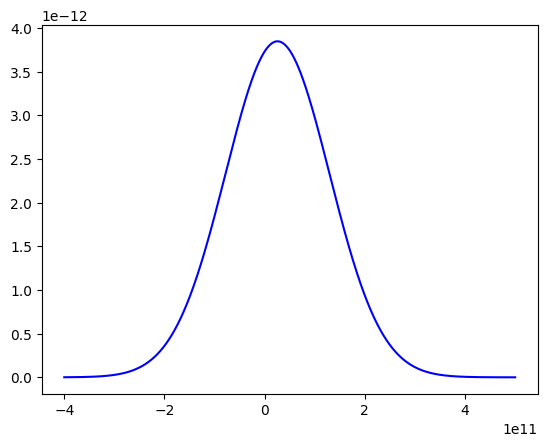

In [17]:
# https://stackoverflow.com/questions/31674195/plot-normal-distribution-given-mean-and-sigma-python
# loc is mean, scale is standard deviation
import pylab
import numpy as np
from scipy.stats import norm
# x = np.linspace(-10000,100000,1000)
x = np.linspace(-40e+10,50e+10,1000)
y = norm.pdf(x, loc=2.562777e+10, scale=1.036925e+11)    # loc = mean, scale = standard deviation
# z = norm.pdf(x, loc=3.540615e+10, scale=1.194430e+11)    # for example
# z1 = norm.pdf(x, loc=298.805901, scale=826.875749)    # for example
# z1 = norm.pdf(x, loc=1.021825, scale=1.505096)    # for example
pylab.plot(x,y, 'b')
# pylab.plot(x,z, 'g')
# pylab.plot(x,z1, 'r')
pylab.show()

In [18]:
print(f'n_samples:             {n_samples:>13}')
print(f'days_lookbacks:        {days_lookbacks}')
print(f'days_eval:             {days_eval:>13}')
print(f'n_top_syms:            {n_top_syms:>13}')
print(f'syms_start:            {syms_start:>13}')
print(f'syms_end:              {syms_end:>13}')
print(f'grp(CAGR/UI)_mean:     {grp_CAGR_d_UI[0]:>13,.3f}')
print(f'grp(CAGR/UI)_std:      {grp_CAGR_d_UI[1]:>13,.3f}')
print(f'grp(CAGR/UI)_mean/std: {grp_CAGR_d_UI[2]:>13,.3f}')
print(f'SPY_CAGR/UI:           {SPY_CAGR_d_UI[0]:>13,.3f}')

n_samples:                         2
days_lookbacks:        [60, 120]
days_eval:                        10
n_top_syms:                       10
syms_start:                        0
syms_end:                          2
grp(CAGR/UI)_mean:           178.762
grp(CAGR/UI)_std:            173.436
grp(CAGR/UI)_mean/std:         1.031
SPY_CAGR/UI:                  -2.378


In [19]:
params = ['date', 'days_lookbacks', 'n_top_syms', 'syms_start', 'syms_end', 'grp_dates', 'top_set_syms_n_freq', 'top_set_syms']
results1 = ['grp(retnStd/UI))_mean',	'grp(retnStd/UI))_std']
results2 = ['grp(CAGR/retnStd)_mean',	'grp(CAGR/retnStd)_std']
results3 = ['grp(CAGR/UI)_mean',	'grp(CAGR/UI)_std', 'SPY_CAGR/UI']
my_cols = params + results1 + results2 + results3
# # Creating Empty DataFrame and Storing it in variable df
# df = pd.DataFrame(columns=my_cols)

# row_add = [grp_dates[-1], days_lookbacks, n_top_syms, syms_start, syms_end, grp_dates, top_set_syms_n_freq, top_set_syms]
# df.loc[len(df)] = row_add

In [ ]:
n_samples, days_lookbacks, days_eval, n_top_syms, syms_start, syms_end

In [ ]:
n_samples	days_lookbacks	days_eval	n_top_syms	syms_start	syms_end	grp(CAGR/UI)_mean	grp(CAGR/UI)_std	grp(CAGR/UI)_mean/std	SPY_CAGR/UI

In [20]:
my_cols

['date',
 'days_lookbacks',
 'n_top_syms',
 'syms_start',
 'syms_end',
 'grp_dates',
 'top_set_syms_n_freq',
 'top_set_syms',
 'grp(retnStd/UI))_mean',
 'grp(retnStd/UI))_std',
 'grp(CAGR/retnStd)_mean',
 'grp(CAGR/retnStd)_std',
 'grp(CAGR/UI)_mean',
 'grp(CAGR/UI)_std',
 'SPY_CAGR/UI']

In [21]:
row_add = [grp_dates[-1], days_lookbacks, n_top_syms, syms_start, syms_end, grp_dates, top_set_syms_n_freq, top_set_syms]
# df.loc[len(df)] = row_add

NameError: name 'grp_dates' is not defined

In [ ]:
  print(f'grp(retnStd/UI):   mean, std, mean/std: {grp_retnStd_d_UI[0]:>13,.3f}, {grp_retnStd_d_UI[1]:>13,.3f}, {grp_retnStd_d_UI[2]:>13,.3f}')
  print(f'grp(CAGR/retnStd): mean, std, mean/std: {grp_CAGR_d_retnStd[0]:>13,.3f}, {grp_CAGR_d_retnStd[1]:>13,.3f}, {grp_CAGR_d_retnStd[2]:>13,.3f}')
  print(f'grp(CAGR/UI):      mean, std, mean/std: {grp_CAGR_d_UI[0]:>13,.3f}, {grp_CAGR_d_UI[1]:>13,.3f}, {grp_CAGR_d_UI[2]:>13,.3f}')